In [1]:
import os
import torch
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from torchmetrics import F1Score

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
device = torch.device('cpu')

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
transform = v2.Compose([
    v2.Grayscale(num_output_channels=1),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

In [4]:
dataset = datasets.ImageFolder(root="data", transform=transform)

Text(0.5, 1.0, 'Primeira imagem')

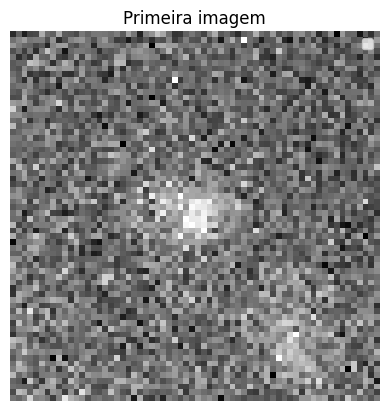

In [5]:
img, label = dataset[0]

plt.imshow(img.squeeze(0), cmap='gray')
plt.legend(f"{dataset.classes[label]}")
plt.axis('off')
plt.title('Primeira imagem')

Text(0.5, 1.0, 'Última imagem')

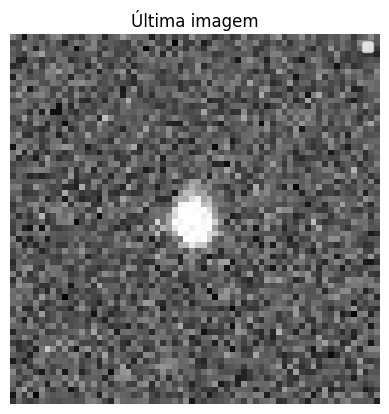

In [6]:
img, label = dataset[-1]

plt.imshow(img.squeeze(0), cmap='gray')
plt.legend(f"{dataset.classes[label]}")
plt.axis('off')
plt.title('Última imagem')

In [7]:
dataloader_noNorm = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)

In [8]:
total_sum = torch.zeros(1)
total_sqsum = torch.zeros(1)
total_pixels = 0

with torch.no_grad():
    for images, labels in dataloader_noNorm:
        b = images.shape[0]
        c = images.shape[1]
        h = images.shape[2]
        w = images.shape[3]

        sum_batch = torch.sum(images, dim=(0, 2, 3))
        sqsum_batch = torch.sum(images**2, dim=(0, 2, 3))
        pixels_batch = b * h * w

        total_sum += sum_batch
        total_sqsum += sqsum_batch
        total_pixels += pixels_batch

In [9]:
mean = total_sum / total_pixels
var = total_sqsum / total_pixels - mean**2
std = torch.sqrt(var)

print(f"Média: {mean.item():.6f}\nDesvio padrão: {std.item():.6f}\nTotal de pixels: {total_pixels:,}")

Média: 0.357345
Desvio padrão: 0.145830
Total de pixels: 16,322,560


In [10]:
m = mean.item()
s = std.item()

print(f"m = {m:.6f}\ns = {s:.6f}")

m = 0.357345
s = 0.145830


In [11]:
train_transform = v2.Compose([
    v2.Grayscale(num_output_channels=1),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[m], std=[s]),
])

In [12]:
val_transform = v2.Compose([
    v2.Grayscale(num_output_channels=1),
    v2.Resize((128, 128)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[m], std=[s])
])

In [13]:
train_dataset = datasets.ImageFolder(root='data', transform=train_transform)

In [14]:
totalsize = len(train_dataset)
train_size = int(0.7 * totalsize)
validate_size = int(0.15 * totalsize)
test_size = totalsize - train_size - validate_size

In [15]:
train_df, validate_df, test_df = random_split(
    train_dataset,[train_size, validate_size, test_size], 
    torch.Generator().manual_seed(42)
    )

In [16]:
train_loader = DataLoader(train_df, batch_size=32, shuffle=True, num_workers=4)
validate_loader = DataLoader(validate_df, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_df, batch_size=32, shuffle=False, num_workers=4)

In [17]:
print(f"Total: {len(train_df + validate_df + test_df)}, Train: {len(train_df)}, Validation: {len(validate_df)}, Test: {len(test_df)}")

Total: 3985, Train: 2789, Validation: 597, Test: 599


In [18]:
torch.manual_seed(42)
it_loader = iter(train_loader)

with torch.no_grad():
    images, labels = next(it_loader)
    mean_batch = images.mean(dim=(0, 2, 3))
    std_batch = images.std(dim=(0, 2, 3))

    print(f"Média do batch: {mean_batch.item():.4f}\nDesvio padrão do batch: {std_batch.item():.5f}")

Média do batch: 0.0726
Desvio padrão do batch: 1.06962


In [19]:
min_val = images.min().item()
max_val = images.max().item()

print(f"Valores de batch pós normalização \nMínimo: {min_val:.6f}\nMáximo: {max_val:.6f}")

Valores de batch pós normalização 
Mínimo: -2.450424
Máximo: 4.406888


In [20]:
train_transform = v2.Compose([
    v2.Grayscale(num_output_channels=1),
    v2.Resize((128, 128)),
    v2.RandomHorizontalFlip(0.5),
    v2.RandomRotation(degrees=10),
    v2.RandomResizedCrop(size=(128, 128), scale=(0.9, 1.0), ratio=(0.98, 1.02)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[m], std=[s])
])

In [21]:
class CNN(nn.Module):
    def __init__(self, num_classes=1, dropout_rate=0.5, conv_dropout=0.3):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout_conv2 = nn.Dropout2d(p=conv_dropout)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout_conv3 = nn.Dropout2d(p=conv_dropout)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(2, 2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))

        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(512, 128)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.adaptive_pool(x)

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)

        return x

In [22]:
model = CNN(num_classes=1, dropout_rate=0.5).to(device)

dummy = torch.randn(1, 1, 128, 128).to(device)
out = model(dummy)

num_params = sum(p.numel() for p in model.parameters())
num_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Output: {out.shape}\nParâmetros: {sum(p.numel() for p in model.parameters()):,}")

Output: torch.Size([1, 1])
Parâmetros: 2,552,257


In [23]:
learning_rate = 0.00005

weight_decay = 1e-6 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.BCEWithLogitsLoss()

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=3,
    min_lr=1e-7
)


In [24]:
num_epochs = 10
f1_metric = F1Score(task='binary')

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    f1_metric.reset()

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        labels = labels.float().unsqueeze(1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        preds = (outputs > 0).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        f1_metric.update(preds, labels.int())

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = 100 * correct / total
    train_f1 = f1_metric.compute().item()

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    val_f1_metric = F1Score(task='binary')

    with torch.no_grad():
        for images, labels in validate_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            labels = labels.float().unsqueeze(1)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            preds = (outputs > 0).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
            val_f1_metric.update(preds, labels.int())

    val_loss /= len(validate_loader.dataset)
    val_acc = 100 * val_correct / val_total
    val_f1 = val_f1_metric.compute().item()

    print(
        f"Epoch [{epoch+1}/{num_epochs}] "
        f"Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% F1: {train_f1:.4f} | "
        f"Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}% F1: {val_f1:.4f}\n"
    )

Epoch [1/10] Train Loss: 0.5499 Acc: 75.76% F1: 0.8619 | Val Loss: 0.5010 Acc: 77.72% F1: 0.8746

Epoch [2/10] Train Loss: 0.5059 Acc: 76.34% F1: 0.8652 | Val Loss: 0.4499 Acc: 77.72% F1: 0.8746

Epoch [3/10] Train Loss: 0.4357 Acc: 78.74% F1: 0.8758 | Val Loss: 0.3813 Acc: 81.91% F1: 0.8877

Epoch [4/10] Train Loss: 0.3654 Acc: 83.08% F1: 0.8953 | Val Loss: 0.3422 Acc: 84.42% F1: 0.8975

Epoch [5/10] Train Loss: 0.3069 Acc: 86.95% F1: 0.9168 | Val Loss: 0.2877 Acc: 86.77% F1: 0.9155

Epoch [6/10] Train Loss: 0.2542 Acc: 89.35% F1: 0.9315 | Val Loss: 0.3019 Acc: 87.44% F1: 0.9229

Epoch [7/10] Train Loss: 0.2066 Acc: 92.11% F1: 0.9489 | Val Loss: 0.2706 Acc: 88.11% F1: 0.9258

Epoch [8/10] Train Loss: 0.1604 Acc: 94.44% F1: 0.9636 | Val Loss: 0.2560 Acc: 90.12% F1: 0.9373

Epoch [9/10] Train Loss: 0.1127 Acc: 96.99% F1: 0.9803 | Val Loss: 0.2875 Acc: 89.11% F1: 0.9322

Epoch [10/10] Train Loss: 0.0688 Acc: 98.49% F1: 0.9901 | Val Loss: 0.2965 Acc: 89.95% F1: 0.9375

